### NIR spectroscopy : PCA LDA machine loogistic regression / Support Vector Machine
- メランチ４種類のスペクトルデータを読み込んで解析を進めます。

In [1]:
# NIR data from Spectrum 100N
import os, sys
import pandas as pd
import numpy as np
pd .options.display.max_rows = 10
df = pd.read_csv('../../../GitHubData/DataScience_AI/data/Spectroscopy/Data_of_4_Meranti species.csv', header=0, index_col=0)

Firstly, plotting all the data to see their trends.

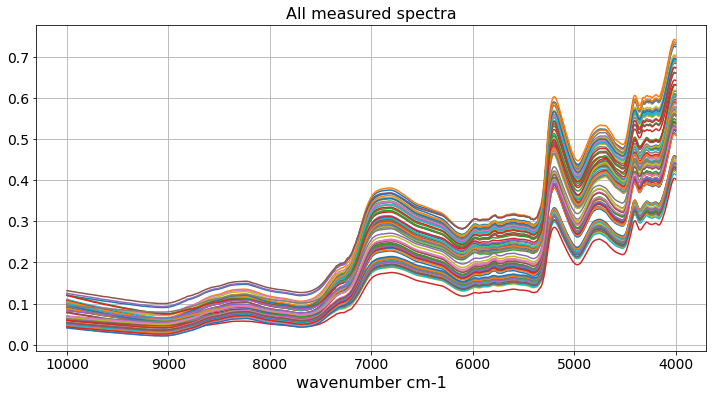

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

wavnum = np.array(df.columns).astype('float')
spectrum=df.transpose()

fig, ax = plt.subplots(figsize=(12,6))
spectrum.plot(ax=ax, legend=False)
ax.set_title("All measured spectra", fontsize=16)
ax.set_xlabel("wavenumber cm-1", fontsize=16)
ax.grid()
ax.tick_params(labelsize=14) 
plt.show()

- 文献によると 
- 800-1100nm いずれのバンドも非常に弱いのでこの領域は 透過性にすぐれている.非破壊分析，無侵襲分析に適 し，近赤外の医学応用や選果機などはこの領域を利用
- 1100-1800nm で，この領域 には XH 伸縮振動の第一，第二倍音のほかに多くの結 合音が観測される.近赤外分光法を用いた基礎研究， 応用研究に最もよく用いられる領域
- 1800-2500nm で，ここで観測されるバンドのほ とんどは結合音によるものである.この領域はかなり 透過性が悪い.
> (ここから原文）近赤外域は3つの領域に分けて考えると都合がよい. 第一の領域は800-1100nm の領域で，この領域で観 測されるバンドは，基準振動の高次倍音(CH，OH， NH 伸縮振動の第2，第3，第4倍音など)と電子吸収 である.いずれのバンドも非常に弱いのでこの領域は 透過性にすぐれている.非破壊分析，無侵襲分析に適 し，近赤外の医学応用や選果機などはこの領域を利用 している.第二の領域は1100-1800nm で，この領域 には XH 伸縮振動の第一，第二倍音のほかに多くの結 合音が観測される.近赤外分光法を用いた基礎研究， 応用研究に最もよく用いられる領域である.第三の領 域は1800-2500nm で，ここで観測されるバンドのほとんどは結合音によるものである.この領域はかなり 透過性が悪い. (近藤みゆき　金赤外分光法による食品の化学的分析、名古屋文理大学紀要、7,23-28 (2007))



| nm   | nm       | cm   | cm       | cm-1  |
| ---- | -------- | ---- | -------- | ----- |
| 800  | 1.00E-09 | 100  | 8.00E-05 | 12500 |
| 1100 | 1.00E-09 | 100  | 1.10E-04 | 9091  |
| 1800 | 1.00E-09 | 100  | 1.80E-04 | 5556  |
| 2500 | 1.00E-09 | 100  | 2.50E-04 | 4000  |


- Calculate 2nd derivative spectra by Savitzky-Golay algorithm. Window-size = 61, fitting function order = 3, seems reasonable. 
- ここからは２次微分をしてスペクトルの規格化をおこなう。
> - (1) A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of Data by Simplified Least Squares Procedures. Analytical Chemistry, 1964, 36 (8), pp 1627-1639. (2) Numerical Recipes 3rd Edition: The Art of Scientific Computing W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery Cambridge University Press ISBN-13: 9780521880688


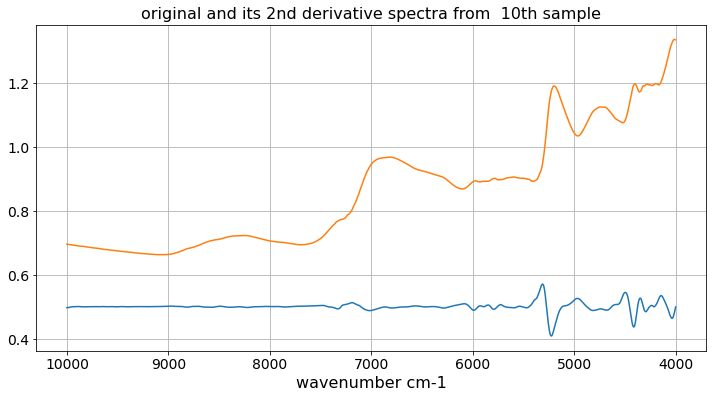

In [3]:
from common.process import savitzky_golay
wavnum = np.array(df.columns).astype('float')
y1 = df.iloc[10]
y2 = savitzky_golay(y1,61,3,2)

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(wavnum ,y2*500+0.5)
ax.plot(wavnum ,y1.T+0.6)
ax.set_title("original and its 2nd derivative spectra from  10th sample", fontsize=16)
ax.set_xlabel("wavenumber cm-1", fontsize=16)
ax.grid()
ax.tick_params(labelsize=14) 
ax.invert_xaxis()
plt.show()

- 前スペクトルの微分を行いプロットする
- 機械学習用のデータとしてエクセル形式で保存する。

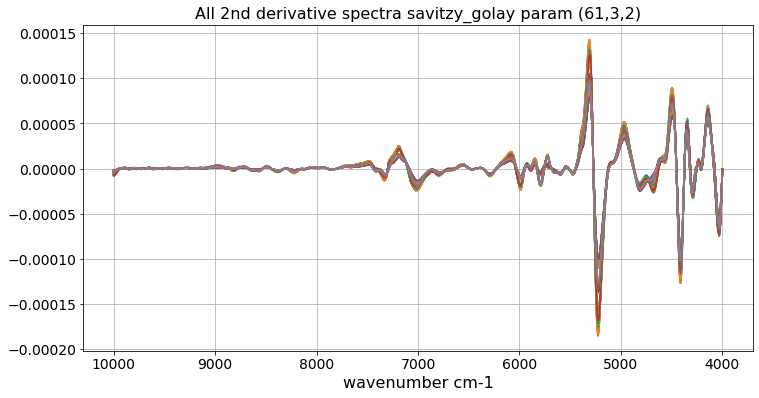

In [4]:
spectra_2nd_deriv = []
for n in range(df.shape[0]):
    y = df.iloc[n]
    spectra_2nd_deriv.append(savitzky_golay(y,61,3,2))
X_data = np.array(spectra_2nd_deriv)

fig, ax = plt.subplots(figsize=(12,6))
plt.plot(wavnum,X_data.T)
ax.set_title("All 2nd derivative spectra savitzy_golay param (61,3,2)", fontsize=16)
ax.set_xlabel("wavenumber cm-1", fontsize=16)
ax.grid()
ax.tick_params(labelsize=14) 
ax.invert_xaxis()
plt.show()

second_dev=pd.DataFrame(X_data ,columns=wavnum,index=df.index)
second_dev.to_excel('../../../GitHubData/Datascience_AI/data/Spectroscopy/2nd_Meranti_.xlsx')

##  ここから下のスクリプトがテキストにあるものと同じ、データは二次微分データから使うように変更したもの。

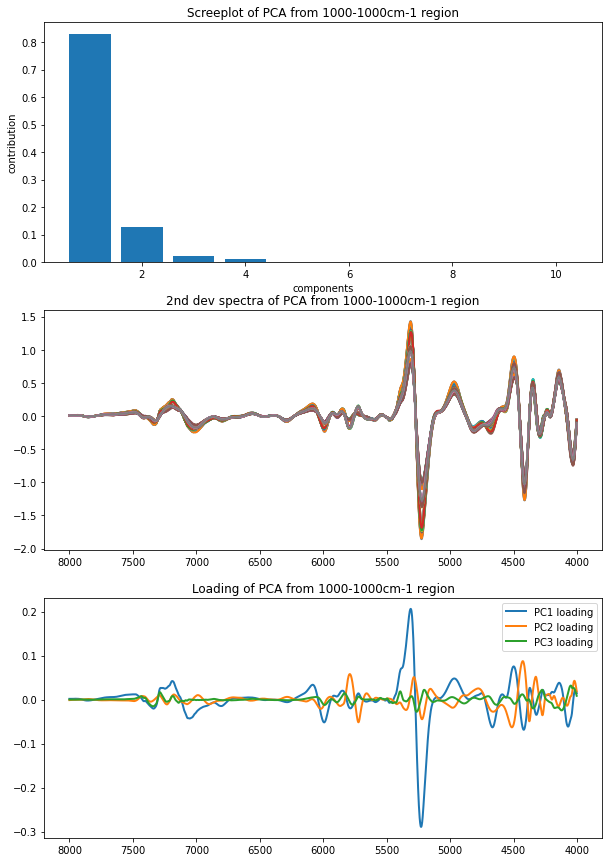

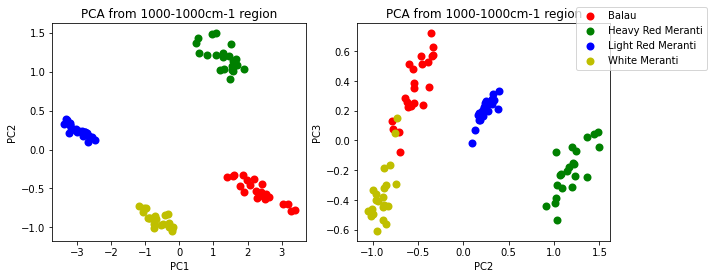

In [5]:
# PCA analyses : wavenuber range  8000-4000 cm-1
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

second_dev_spectrum=pd.read_excel('../../../GitHubData/Datascience_AI/data/Spectroscopy/2nd_Meranti_.xlsx', index_col=0)
#
wv_max=8000
wv_min=4000
#
wvmax=int((10000-wv_max)/2)
wvmin=int((10000-wv_min)/2)
wvnum=second_dev_spectrum.columns[wvmax:wvmin]
X = second_dev_spectrum.iloc[:,wvmax:wvmin]
X = X*10e3  # 

target_names=np.unique(second_dev_spectrum.index)
tmp = pd.get_dummies(second_dev_spectrum.index)
X_category = tmp.values.argmax(1) # make strings into numbers 0,1,2,...
sp_names = second_dev_spectrum.index

title = 'PCA from '+str(wvmax)+'-'+str(wvmax)+'cm-1 region' 

pca = PCA(n_components=10)
X_r = pca.fit(X).transform(X)
        
fig, axes = plt.subplots(nrows=3, figsize=(10,15))
#　寄与率
axes[0].bar(np.arange(1,11,1), pca.explained_variance_ratio_, align = "center")
axes[0].set_title("Screeplot of "+title)
axes[0].set_xlabel("components")
axes[0].set_ylabel("contribution")
# ２次微分曲線
axes[1].plot(wvnum,X.T,linewidth = 2 ) ## x 10e3 
axes[1].set_title("2nd dev spectra of "+title)
axes[1].invert_xaxis()
# 因子付加量
loadings = pca.components_*np.c_[np.sqrt(pca.explained_variance_)]
axes[2].plot(wvnum,loadings[0],linewidth = 2, label='PC1 loading')
axes[2].plot(wvnum,loadings[1],linewidth = 2, label='PC2 loading' )
axes[2].plot(wvnum,loadings[2],linewidth = 2, label='PC3 loading' )
axes[2].set_title("Loading of "+title)
axes[2].invert_xaxis()
axes[2].legend()
plt.show()
        
#PCA 3D plot
colors = ['r', 'g', 'b','y' ]
# fig = plt.figure(1, figsize=(8, 6))
# plt.clf()
# ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
# plt.cla()
# lw=5
# for color, i, target_name in zip(colors, list(range(max(X_category)+1)), target_names):
#     ax.scatter(X_r[X_category==i, 0], X_r[X_category==i, 1], X_r[X_category==i, 2], color=color, lw=lw, label=target_name) 
# ax.set_xlabel('PC1')
# ax.set_ylabel('PC2')
# ax.set_zlabel('PC3')
# ax.set_title(title, fontsize=20)
# ax.legend(bbox_to_anchor=(1.1, 0.8), shadow=False, scatterpoints=1)
         
# PCA
fig, axes = plt.subplots(ncols=2,figsize=(10,4))
lw = 2 # line width
for color, i, target_name in zip(colors, list(range(max(X_category)+1)), target_names):
    axes[0].scatter(X_r[X_category == i, 0], X_r[X_category == i, 1], color=color,lw=lw,label=target_name)
axes[0].set_title(title)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

for color, i, target_name in zip(colors, list(range(max(X_category)+1)), target_names):
    axes[1].scatter(X_r[X_category == i, 1], X_r[X_category == i, 2], color=color, lw=lw,label=target_name)
axes[1].legend(bbox_to_anchor=(1.4, 1.1), shadow=False, scatterpoints=1)
axes[1].set_title(title)
axes[1].set_xlabel('PC2')
axes[1].set_ylabel('PC3')
plt.show()


#### End of program

In [6]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from mlxtend.plotting import plot_decision_regions
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score

# X_train, X_test, y_train, y_test = train_test_split(X,X_category, test_size=0.3, random_state=0)

# LDA=LinearDiscriminantAnalysis(n_components=3)
# x_train_lda=LDA.fit_transform(X_train, y_train)
# X_test_lda = LDA.transform(X_test)
# lr = LogisticRegression()

# lr.fit(x_train_lda, y_train)
# y_pred = lr.predict(X_test_lda)
# print('Accuracy: %.2f' % accuracy_score(y_test,y_pred))


# title = "LDA from 9000-8000 cm-1 region"

# #PCA 3D plot
# colors = ['r', 'g', 'b','y' ]
# fig = plt.figure(1, figsize=(8, 6))
# plt.clf()
# ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
# plt.cla()
# lw=5
# for color, i, target_name in zip(colors, list(range(max(y_train)+1)), target_names):
#     ax.scatter(x_train_lda[y_train==i, 0], x_train_lda[y_train==i, 1], x_train_lda[y_train==i, 2], color=color, lw=lw, label=target_name) 
# ax.set_xlabel('LD1')
# ax.set_ylabel('LD2')
# ax.set_zlabel('LD3')
# ax.set_title(title, fontsize=20)
# ax.legend(bbox_to_anchor=(1.1, 0.8), shadow=False, scatterpoints=1)
         
# # PCA
# fig, axes = plt.subplots(ncols=2,figsize=(10,4))
# lw = 2 # line width
# for color, i, target_name in zip(colors, list(range(max(y_train)+1)), target_names):
#     axes[0].scatter(x_train_lda[y_train == i, 0], x_train_lda[y_train == i, 1], color=color,lw=lw,label=target_name)
# axes[0].set_title(title)
# axes[0].set_xlabel('LD1')
# axes[0].set_ylabel('LD2')

# for color, i, target_name in zip(colors, list(range(max(y_train)+1)), target_names):
#     axes[1].scatter(x_train_lda[y_train == i, 1], x_train_lda[y_train == i, 2], color=color, lw=lw,label=target_name)
# axes[1].legend(bbox_to_anchor=(1.4, 1.1), shadow=False, scatterpoints=1)
# axes[1].set_title(title)
# axes[1].set_xlabel('LD2')
# axes[1].set_ylabel('LD3')
# plt.show()


In [7]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from mlxtend.plotting import plot_decision_regions
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# %matplotlib inline

# second_dev_spectrum=pd.read_excel('../../../GitHubData/Datascience_AI/data/Spectroscopy/2nd_Meranti_.xlsx', index_col=0)

# wv_max=9000
# wv_min=8000

# wvmax=int((10000-wv_max)/2)
# wvmin=int((10000-wv_min)/2)
# wvnum=second_dev_spectrum.columns[wvmax:wvmin]
# X = second_dev_spectrum.iloc[:,wvmax:wvmin]
# X = X*10e3  # 

# target_names=np.unique(second_dev_spectrum.index)
# tmp = pd.get_dummies(second_dev_spectrum.index)
# X_category = tmp.values.argmax(1) # make strings into numbers 0,1,2,...
# X_train, X_test, y_train, y_test = train_test_split(X, X_category, test_size=0.3, random_state=0)

# LDA=LinearDiscriminantAnalysis(n_components=3)
# x_train_lda=LDA.fit_transform(X_train, y_train)
# x_test_lda = LDA.transform(X_test)

# lr = LogisticRegression()

# lr.fit(x_train_lda, y_train)
# y_pred = lr.predict(x_test_lda)


# title = 'LDA from '+str(wvmax)+'-'+str(wvmax)+'cm-1 region: Accuuracy:%.2f' % accuracy_score(y_test,y_pred) 

# fig, ax = plt.subplots(figsize=(10,4))
# ax.plot(wvnum,X.T,linewidth = 2 ) ## x 10e3 
# ax.set_title("2nd dev spectra of "+title)
# ax.invert_xaxis()

# fig, ax = plt.subplots(ncols=2, figsize=(10,4))
# ds=[(x_train_lda[:,0:2], y_train),(x_test_lda[:,0:2], y_test)]
# for i in range(len(ds)):
#     plot_decision_regions(ds[i][0], ds[i][1], clf=lr,ax=ax[i])
#     ax[i].set_xlabel('LD 1')
#     ax[i].set_ylabel('LD 2')
#     ax[i].legend(loc='lower left')

# plt.show()

# x_train_lda[:,0:2].shape

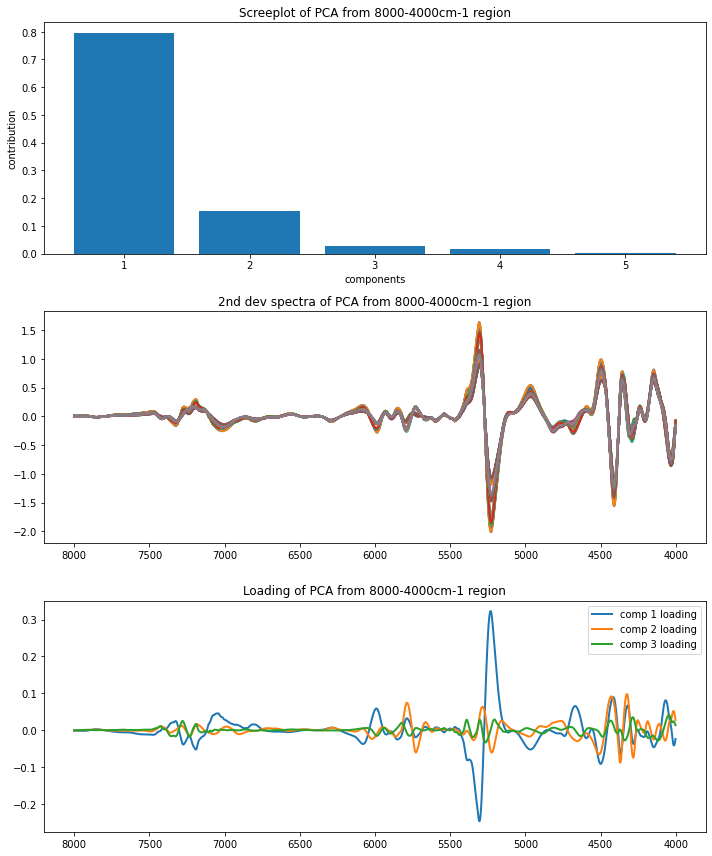

Support Vector Machine is selected


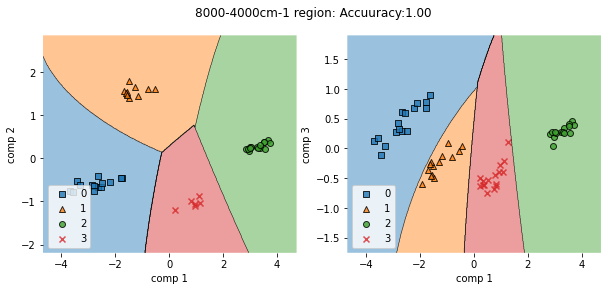

In [8]:
def analysis_NIR(fl, wmax, wmin, svgo, method,ncomp,classifier):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from common.process import savitzky_golay
    from sklearn.decomposition import PCA
    from sklearn.svm import SVC
    from mpl_toolkits.mplot3d import Axes3D
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    from mlxtend.plotting import plot_decision_regions
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score
    %matplotlib inline

    df = pd.read_csv(fl, header=0, index_col=0)
    wavnum = np.array(df.columns).astype('float')
    spectrum=df.transpose()
    spectra_2nd_deriv = []
    for n in range(df.shape[0]):
        y = df.iloc[n]
        spectra_2nd_deriv.append(savitzky_golay(y,svgo[0],svgo[1],svgo[2]))
    X_data = np.array(spectra_2nd_deriv)

    # make database for machine learning
    second_dev=pd.DataFrame(X_data ,columns=wavnum,index=df.index)
    target_names=np.unique(second_dev.index)
    tmp = pd.get_dummies(second_dev.index)
    #
    wv_max=wmax
    wv_min=wmin
    #
    wvmax=int((10000-wv_max)/2)
    wvmin=int((10000-wv_min)/2)
    wvnum=second_dev.columns[wvmax:wvmin]
    X = second_dev.iloc[:,wvmax:wvmin]
    X = X*10e3  # 
    X_category = tmp.values.argmax(1) # make strings into numbers 0,1,2,...
    X_train, X_test, y_train, y_test = train_test_split(X, X_category, test_size=0.3, random_state=0)

    target_names=np.unique(second_dev.index)
    tmp = pd.get_dummies(second_dev.index)
    X_category = tmp.values.argmax(1) # make strings into numbers 0,1,2,...
    sp_names = second_dev.index
    if method=='pca':
        title = 'PCA from '+str(wmax)+'-'+str(wmin)+'cm-1 region'
        pca = PCA(n_components=ncomp)
        x_train_d = pca.fit_transform(X_train)
        x_test_d = pca.transform(X_test)
        accum_val=pca.explained_variance_ratio_
        loadings = pca.components_*np.c_[np.sqrt(pca.explained_variance_)]
        plot_spectrum(wvnum,X.T,ncomp,accum_val,loadings,title)
        
    elif method=='lda':
        #ncomp=3
        title = 'LDA from '+str(wmax)+'-'+str(wmin)+'cm-1 region'
        LDA=LinearDiscriminantAnalysis(n_components=2,store_covariance=True)
        x_train_d =LDA.fit_transform(X_train, y_train)
        accum_val=LDA.explained_variance_ratio_
        x_test_d = LDA.transform(X_test)
        loadings = LDA.coef_
        plot_spectrum(wvnum, X.T,2,accum_val,loadings,title)        
    else:
        print('please specify method of analysis PCA or LDA')
        
    if classifier=='lr':
        print('Logistic Regression is selected')
        myclf = LogisticRegression()
        
    elif classifier == 'svc':
        print('Support Vector Machine is selected')
        myclf = SVC()
        
    else:
        print('Please select one of the classifier (lr or svc)')
        
    myclf.fit(x_train_d, y_train)
    y_pred = myclf.predict(x_test_d)
    title = str(wmax)+'-'+str(wmin)+'cm-1 region: Accuuracy:%.2f' % accuracy_score(y_test,y_pred) 
    
    fig, ax = plt.subplots(ncols=2, figsize=(10,4))
    

#for i in range(len(ds)):
    value=0.5
    width=1
    plot_decision_regions(x_train_d, y_train,feature_index=[0,1], \
                        filler_feature_values={2: value, 3:value, 4:value},\
                        filler_feature_ranges={2: width, 3: width, 4:width}, \
                          clf=myclf,ax=ax[0],zoom_factor=1)
    ax[0].set_xlabel('comp 1')
    ax[0].set_ylabel('comp 2')
    ax[0].legend(loc='lower left')
    ax[0]
#fcommpo1 and comp 3
    value=0.3
    width=10
    
    plot_decision_regions(x_train_d, y_train,feature_index=[0,2], \
                        filler_feature_values={1: value, 3:value, 4:value},\
                        filler_feature_ranges={1: width, 3: width, 4:width}, \
                          clf=myclf,ax=ax[1],zoom_factor=1)
    ax[1].set_xlabel('comp 1')
    ax[1].set_ylabel('comp 3')
    ax[1].legend(loc='lower left')
    ax[1]
    plt.suptitle(title)
    plt.show()

def plot_spectrum(x, y, ncomp, accum_val,loadings,title):
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    fig, axes = plt.subplots(nrows=3, figsize=(10,12))
    #　寄与率
    axes[0].bar(np.arange(1,ncomp+1,1), accum_val, align = "center")
    axes[0].set_title("Screeplot of "+title)
    axes[0].set_xlabel("components")
    axes[0].set_ylabel("contribution")
    # ２次微分曲線
    axes[1].plot(x,y,linewidth = 2 ) ## x 10e3 
    axes[1].set_title("2nd dev spectra of "+title)
    axes[1].invert_xaxis()
    # 因子付加量    
    axes[2].plot(x,loadings[0],linewidth = 2, label='comp 1 loading')
    axes[2].plot(x,loadings[1],linewidth = 2, label='comp 2 loading' )
    axes[2].plot(x,loadings[2],linewidth = 2, label='comp 3 loading' )
    axes[2].set_title("Loading of "+title)
    axes[2].invert_xaxis()
    axes[2].legend()
    plt.tight_layout()
    #fig.suptitle(title, fontsize=14)
    plt.show()

# def plot_decision(tr_x,tr_l,te_x,te_l,clf_model):
#     import matplotlib.pyplot as plt
#     from mlxtend.plotting import plot_decision_regions
#     %matplotlib inline

    

    
##******************
import pandas as pd
import numpy as np
fl='../../../GitHubData/DataScience_AI/data/Spectroscopy/Data_of_4_Meranti species.csv'
analysis_NIR(fl,8000,4000,[51,3,2],'pca',5,'svc')

